# **Interest Point Detection and Description**

**Required Reading**

1. [Szeliski Section 4.1](http://szeliski.org/Book)

**Additional Reading/Viewing**

1. [OpenCV Feature Detection + Description Tutorial](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_table_of_contents_feature2d/py_table_of_contents_feature2d.html)
2. [Joseph Redmon's awesome computer vision course - lecture 6](https://www.youtube.com/watch?v=bn4KHa_zWuQ)
3. [Joseph Redmon's awesome computer vision course - lecture 7](https://youtu.be/taty6lPVcmA)
4. [UCF Computer Vision Video - Lecture 04 - Interest Point Detection](https://youtu.be/_qgKQGsuKeQ)
5. [UCF Computer Vision Video - Lecture 05 - Scale-invariant Feature Transform (SIFT)](https://youtu.be/NPcMS49V5hg)
6. [Learning OpenCV by Bradski & Kaehler Chapter 10](https://www.amazon.com/Learning-OpenCV-Computer-Vision-Library/dp/0596516134/ref=sr_1_4?s=books&ie=UTF8&qid=1538431072&sr=1-4&keywords=Learning+OpenCV)
7. [Forsyth + Ponce Chapter 5](https://www.pearson.com/us/higher-education/product/Forsyth-Computer-Vision-A-Modern-Approach/9780130851987.html)

---

**Recommended** [Jupyter Theme](https://github.com/dunovank/jupyter-themes) for viewing this notebook:

````
jt -t grade3 -cellw=90% -fs=14 -tfs=14 -ofs=14
````

and for presenting:

````
jt -t grade3 -cellw=90% -fs=20 -tfs=20 -ofs=20
````

![](../graphics/keypoint_matching-01.png)

Today we're going to talk about interest point detection and description. There are quite a few solutions to interesting computer vision problems that rely on interest point detection and matching between images, such as:
- 3D Reconsruction
- Object Tracking
- Stereo camera depth estimation
- Stereo camera calibration
- Image retreival and indexing
- SLAM (Simultaneous Localization and Mapping)
- Visual Odometry
- Image stitching/panoramas
- Object Recognition
- Lots of other cool stuff. 

## **Why this problem is hard**

---

![](../graphics/feature_comparison-01.png)

- Which points above do you think would be easiest to track between images?
- The answer can be a little tricky due to the [aperture problem](https://en.wikipedia.org/wiki/Motion_perception#The_aperture_problem).
- How could we automatically detect such points?

---

## **Moravec's Corner Detector**

![](../graphics/moravec_corners-01.png)

- Let's give a little thought to [Moravec's corner detector](http://www.frc.ri.cmu.edu/~hpm/project.archive/robot.papers/1977/aip.txt):

# $$
E_{x,y} = \sum_{u, v} w_{u, v}(I_{x+u, y+v} - I_{u, v})^2
$$

- $I$ is our image
- $w$ is a window function composed of ones in a small window around $x, y$, and zeros everywhere else.
- $x, y$ are {(1,0), (1,1), (0, 1), (-1, 1)}.
- To find corners using moravec's corner detector, we compute $E_{x,y}$ at each pixel by taking the minimum value return by our equation across the 5 $x,y$ values shown above. We then threshold our $E$ values, and pixels with values above some threshold are called corners.
- Now, what is the equation doing? 
- Can you think of a visual description? 
- How might this equation help us detect corners?

---

![](../graphics/spacer_small-01.png)

- In 1988, Harris and Stephens published a number of [improvements to Moravec's corner detector](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.434.4816&rep=rep1&type=pdf).
- We won't get too deep into the mathematics here.

![](../graphics/harris_improvements-01.png)

## **OpenCV Time**

- OpenCV has an [implementation of the Harris Corner Detector](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_features_harris/py_features_harris.html), let's experiment with this a bit.
- Fun side note, the Harris Corner Detector makes use of the Sobel Operator!

In [1]:
%pylab inline
import cv2

Populating the interactive namespace from numpy and matplotlib


In [2]:
im1 = imread('../data/small/image_00.jpg')

In [3]:
im1.shape

(540, 960, 3)

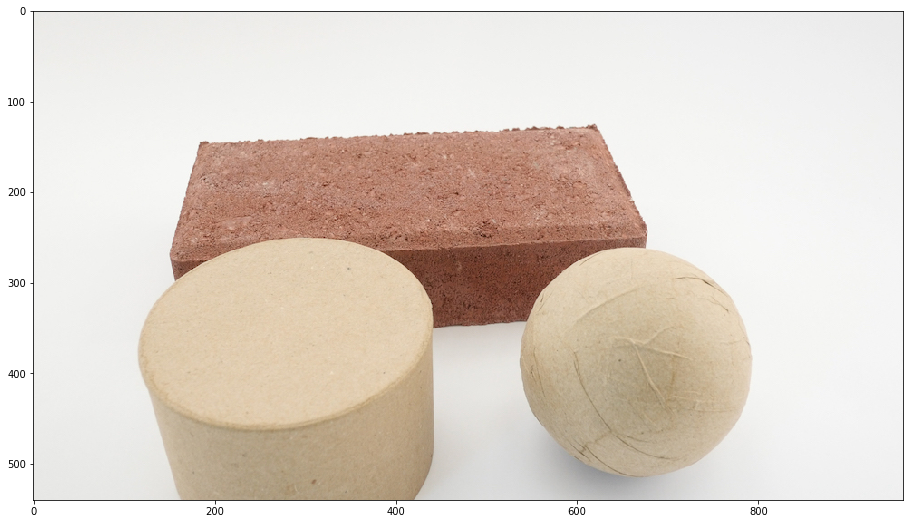

In [4]:
fig = figure(0, (18, 9))
imshow(im1)

---

- First we need to convert to grayscale. 
- Since we're using opencv, let's use opencv to convert to grayscale. 

In [5]:
gray_1 = cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

One nice thing about opencv is that since it's written in C++, it's generally quite a bit faster than python:

In [6]:
def convert_to_grayscale(color_image):
    return np.mean(color_image, axis = 2)

In [7]:
# %timeit convert_to_grayscale(im1)

In [8]:
# %timeit cv2.cvtColor(im1, cv2.COLOR_RGB2GRAY)

---

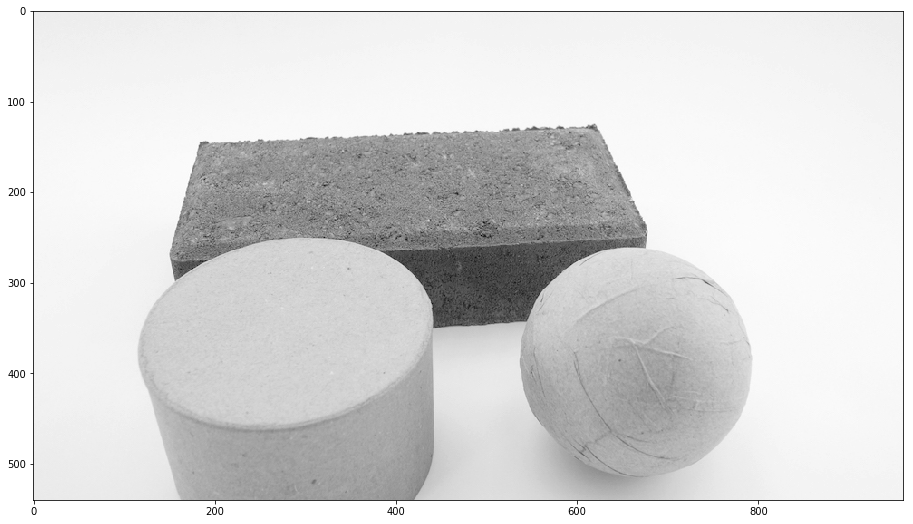

In [9]:
fig = figure(0, (18, 9))
imshow(gray_1, cmap = 'gray')

## Compute Harris Corners:

In [10]:
corners = cv2.cornerHarris(gray_1, 
                     blockSize = 8, 
                     ksize = 3, 
                     k =  0.04)

Alright, now what has opencv given us?

In [11]:
corners.shape

(540, 960)

**Why is the the dimension of our output?**

---

![](../graphics/spacer_small-01.png)

![](../graphics/spacer_small-01.png)

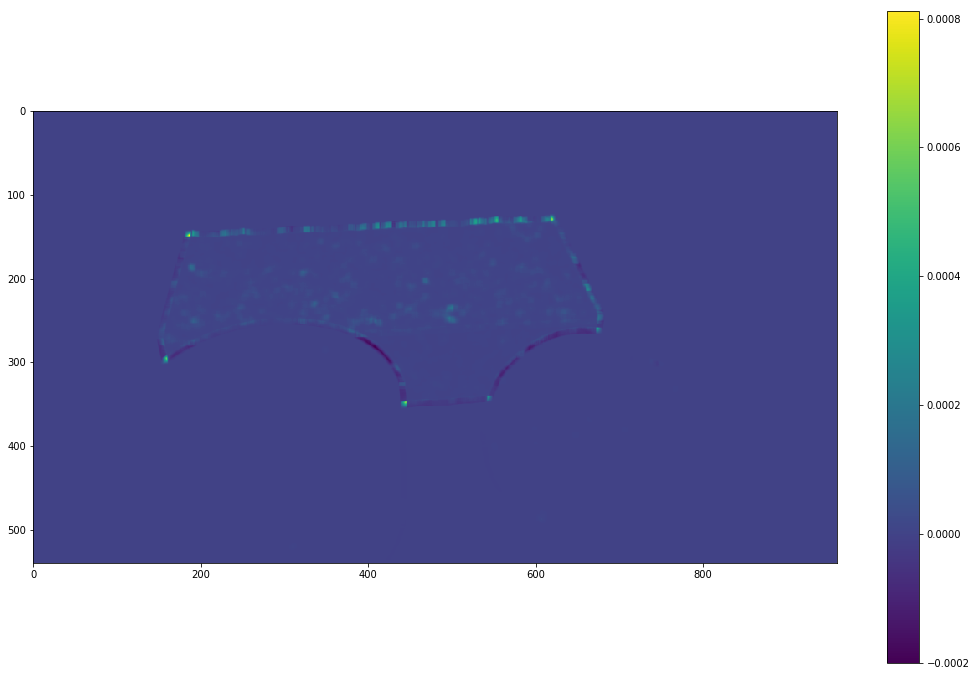

In [12]:
fig = figure(0, (18,12))
imshow(corners)
colorbar()

- What we're getting from this opencv method is not so much the corners, but a "corner score".
- Notice our detections look ok, but are a little noisy?
- **How might we reduce our noise here?**

---

![](../graphics/spacer_small-01.png)

- This might be a good job for some gaussian blur.

In [13]:
gray_1_blurred = cv2.GaussianBlur(gray_1, ksize = (11, 11), sigmaX = 3)

Text(0.5,1,'So Blurrrrry')

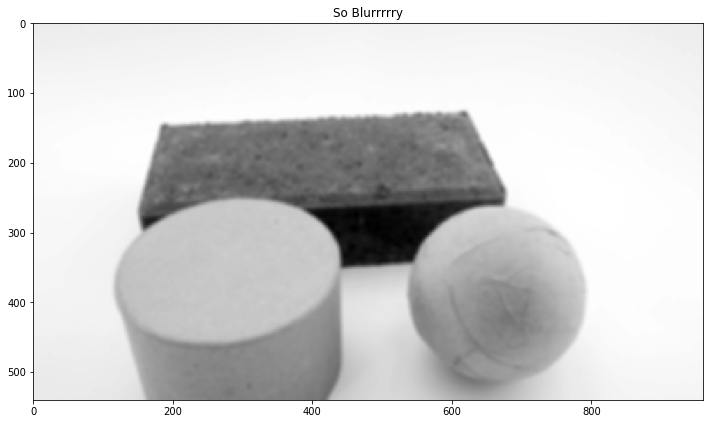

In [14]:
fig = figure(0, (12,9))
imshow(gray_1_blurred, cmap = 'gray')
title('So Blurrrrry')

In [15]:
corners = cv2.cornerHarris(gray_1_blurred, 
                     blockSize = 8, 
                     ksize = 3, 
                     k =  0.04)

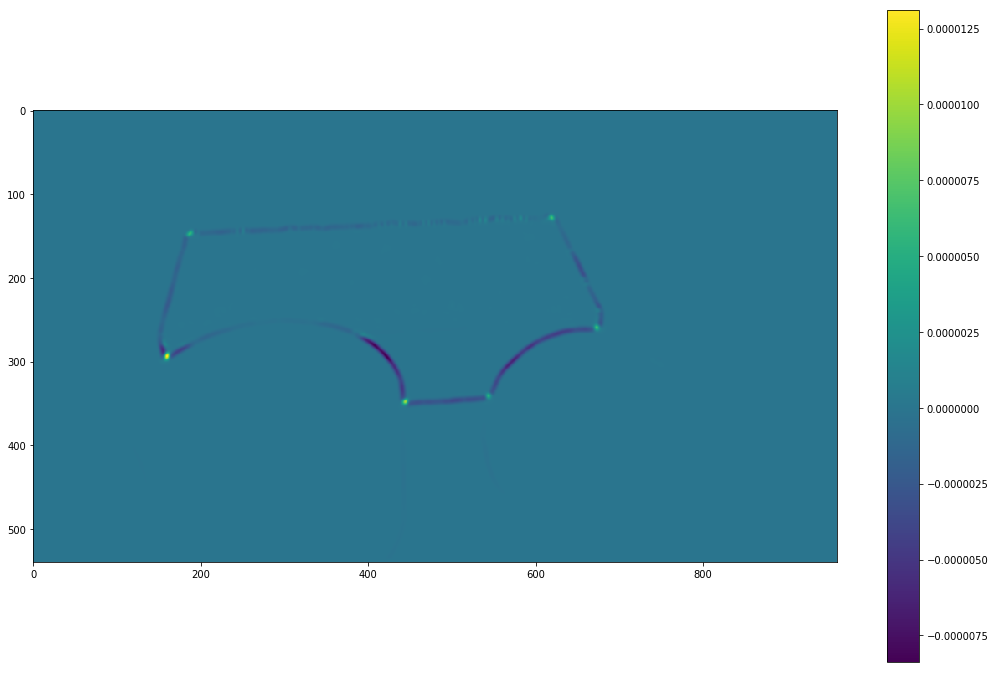

In [16]:
fig = figure(0, (18,12))
imshow(corners)
colorbar()

- Alright, this is looking pretty good! Notice that we're getting some pretty reasonable corner detections!
- Let's threshold and pick out some actual values.

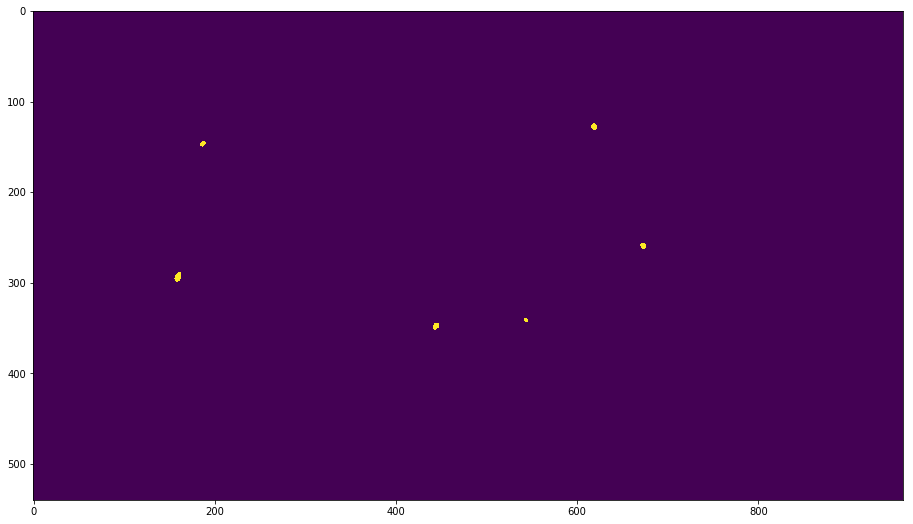

In [17]:
fig = figure(0, (18, 9))
threshold = 0.2
imshow(corners>threshold*corners.max())

## **See any potential issues here?**

---

- The harris corner detector is picking out our corners reasonably well, but we're getting multiple detections per corner. 
- Fixing problems like this is often called **non-maximum supression**.
- Coding these solutions takes some time, so let's rely on opencv here again, and use another nice function called [goodFeaturesToTrack](https://docs.opencv.org/3.0-beta/modules/imgproc/doc/feature_detection.html#goodfeaturestotrack).
- This name comes from a [1994 paper](http://www.ai.mit.edu/courses/6.891/handouts/shi94good.pdf) written by Jianbo Shi and Carlo Tomasi. 

![](../graphics/shi_and_tomasi_paper-01.png)

- In this paper (cited ~9000 times!), Shi and Tomasi make a minor improvment to the Harris corner detector, but more importantly develop a method to choose features by how well they are tracked. 
- The OpenCV implementation of Shi and Tomasi's detector includes the non-maximum suppression we would like here. 
- Let's check it out:

In [18]:
corners = cv2.goodFeaturesToTrack(gray_1, 
                                  maxCorners = 50, 
                                  qualityLevel = 0.1, 
                                  minDistance = 25)

In [19]:
corners.shape

(50, 1, 2)

- Why do you think this is the shape of our output?
- OpenCV dimensions can be a little wierd - this a good quirk to be aware of when using the library.

In [20]:
corners

array([[[184., 146.]],

       [[442., 349.]],

       [[189., 186.]],

       [[157., 297.]],

       [[227., 144.]],

       [[662., 211.]],

       [[476., 134.]],

       [[325., 140.]],

       [[410., 136.]],

       [[468., 202.]],

       [[524., 131.]],

       [[584., 130.]],

       [[295., 141.]],

       [[378., 138.]],

       [[497., 236.]],

       [[552., 128.]],

       [[602., 148.]],

       [[321., 250.]],

       [[544., 342.]],

       [[405., 248.]],

       [[619., 126.]],

       [[675., 261.]],

       [[562., 249.]],

       [[379., 259.]],

       [[438., 136.]],

       [[321., 194.]],

       [[646., 177.]],

       [[360., 218.]],

       [[159., 268.]],

       [[349., 246.]],

       [[436., 232.]],

       [[180., 223.]],

       [[539., 192.]],

       [[632., 240.]],

       [[188., 249.]],

       [[604., 189.]],

       [[582., 289.]],

       [[360., 162.]],

       [[267., 220.]],

       [[500., 192.]],

       [[299., 207.]],

       [[647., 3

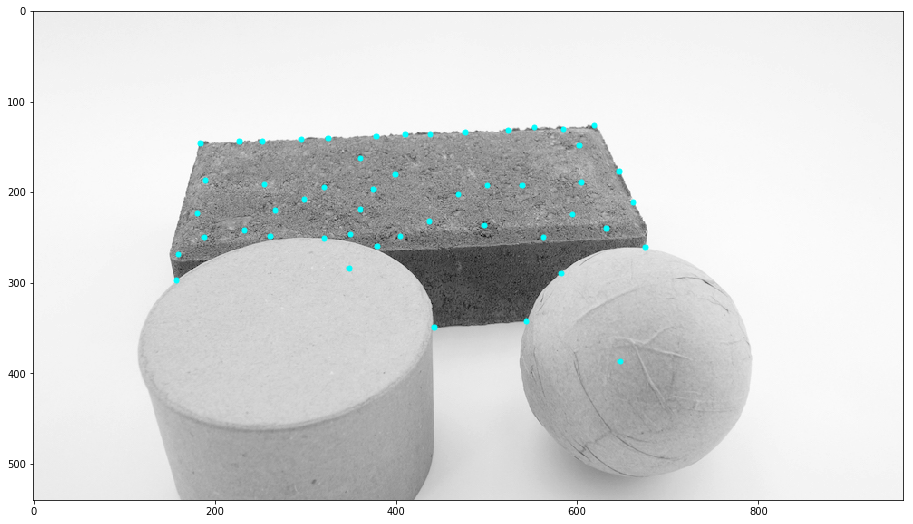

In [21]:
fig = figure(0, (18, 9))
imshow(gray_1, cmap = 'gray')
scatter(corners[:, 0, 0], corners[:,0,1], c = (0, 1, 1), s = 25)

- That's pretty good! We now have points instead of clumps thanks to opencv's non-maximum supression. 
- Now, quick side note - some of these "corners/interest points/features" don't actually correspond to **physical points in the real world**. Can you spot them?
- This is a real problem. Shi and Tomasi propose one solution to detect and remove these problematic points, and we'll eliminate points like this later in our pipeline by fitting a motion model between frames. 

---

## **Tracking?**

- So we have some keypoints that *should* be relatively "trackable" between images, but how do we actually do the tracking??
- Let's import a second image of the same scene and give this some thought.

In [22]:
im2 = imread('../data/small/image_03.jpg')
gray_2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

In [23]:
images_together = np.hstack((gray_1, gray_2))

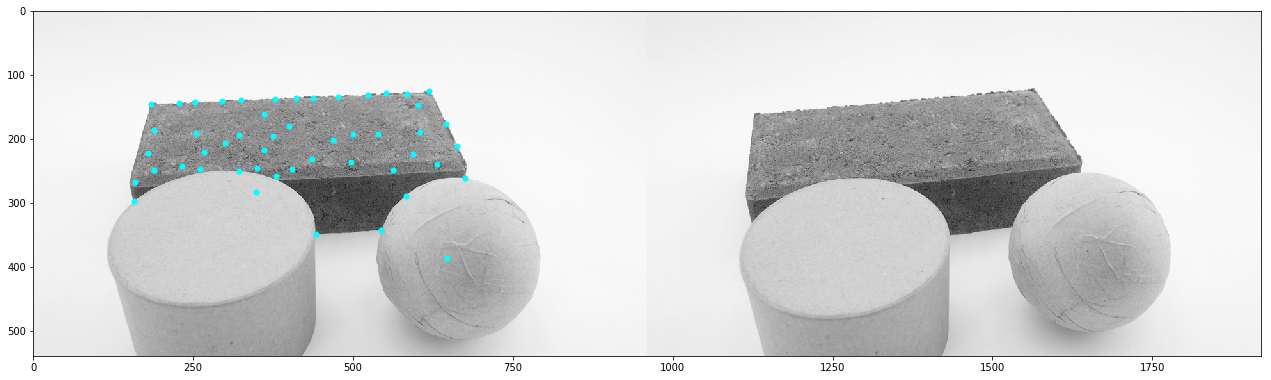

In [24]:
fig = figure(0, (22, 9))
imshow(images_together, cmap = 'gray')
scatter(corners[:, 0, 0], corners[:,0,1], c = (0, 1, 1), s = 25)

## **How do we find the corresponding interest points in our second image?**

![](../graphics/spacer_small-01.png)

- Well, it depends. 
- If our images are pretty similar, for example, consucutive frames in a video, then a **sparse optical flow** method may work well. 
- One of the most popular sparse optical flow methods is the [Lucas Kanade Method](https://en.wikipedia.org/wiki/Lucas%E2%80%93Kanade_method).
- Takeo Kanade is one of the most prolific researchers in Computer Vision - [here's](https://www.youtube.com/watch?v=0B9hhOTYa_I) a great talk from him about his life + research. 

## **The Lucas Kanade Method + Optical Flow**

![](../graphics/lucas_and_kanade_paper-01.png)

- The Lucas Kanade method allows us to efficiently search for matches to our interest points using gradient information from the images. 

![](../graphics/baker_matthews-01.png)

- Here's a nice summary image from [Baker and Matthews 2004](https://link.springer.com/content/pdf/10.1023/B:VISI.0000011205.11775.fd.pdf).
- Like many algorithms in this module, Lucas Kanade is pretty complex. The mathematics are very interesting, but we don't have time to cover them in detail here. We'll focus on what we can do with these algorithms.
- OpenCV has a nice built in method:

In [25]:
nextPts, status, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, corners, None)

In [26]:
nextPts

array([[[168.31017, 161.65594]],

       [[473.3532 , 349.55093]],

       [[180.9221 , 202.42938]],

       [[163.26546, 328.5555 ]],

       [[212.17638, 157.78586]],

       [[658.9936 , 203.43083]],

       [[463.253  , 136.03535]],

       [[312.0527 , 148.98965]],

       [[397.68292, 141.04515]],

       [[468.01648, 204.52953]],

       [[510.66663, 130.75981]],

       [[569.77893, 127.23373]],

       [[281.55066, 151.38199]],

       [[365.67813, 144.51346]],

       [[502.62897, 237.09756]],

       [[538.365  , 126.61617]],

       [[591.0424 , 144.39557]],

       [[352.16638, 261.46432]],

       [[569.6636 , 338.32047]],

       [[423.2977 , 255.1962 ]],

       [[603.99756, 121.7436 ]],

       [[677.1991 , 253.24219]],

       [[578.0598 , 245.59973]],

       [[395.1923 , 265.86996]],

       [[425.63162, 139.8616 ]],

       [[318.05948, 203.82611]],

       [[639.01776, 171.72266]],

       [[362.40375, 226.36456]],

       [[162.2009 , 288.0358 ]],

       [[362.8

In [27]:
nextPts.shape

(50, 1, 2)

In [28]:
# status

- LK won't always work, and when the algorithm fails, it will let us know by returning a 0 in the "status" vector
- Let's filter out the corners where our algorithm failed to converge:

In [29]:
nextPts = nextPts[status[:,0]==1, :, :]
corners_filtered = corners[status[:,0]==1, :, :]

In [30]:
nextPts.shape

(50, 1, 2)

Now, let's have a look at out matches!

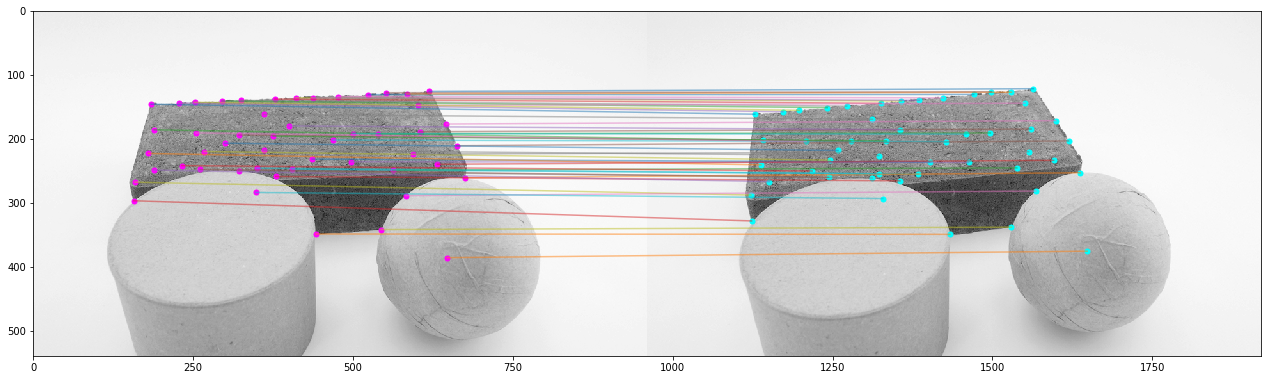

In [31]:
fig = figure(0, (22, 9))
imshow(images_together, cmap = 'gray')

for i in range(nextPts.shape[0]):
    plot([corners_filtered[i, 0, 0], nextPts[i, 0, 0] + gray_1.shape[1]], 
         [corners_filtered[i, 0, 1], nextPts[i, 0, 1]], alpha = 0.5)

scatter(corners_filtered[:, 0, 0], corners_filtered[:,0,1], c = (1, 0, 1), s = 25)
scatter(nextPts[:, 0, 0] + gray_1.shape[1], nextPts[:,0,1], c = (0, 1, 1), s = 25)

- Pretty good, right?
- Now, let visualize our matches in a slightly different way. 
- We'll plot lines from the old to new locations on top of our new image.

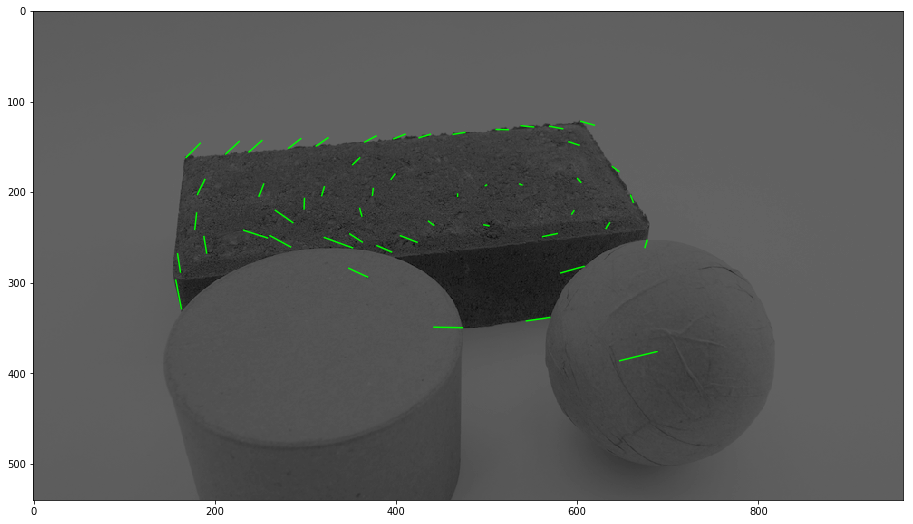

In [32]:
fig = figure(0, (22, 9))
imshow(gray_2*0.4, cmap = 'gray', vmax = 255, vmin = 0) #Darken image to make it easier to see flow lines

for i in range(nextPts.shape[0]):
    plot([corners_filtered[i, 0, 0], nextPts[i, 0, 0]], 
         [corners_filtered[i, 0, 1], nextPts[i, 0, 1]], alpha = 1.0, c = (0, 1, 0))

- Now it may be clear why this method is called **optical flow**. 
- Our "flow" lines give use a nice feeling four how our camera is moving relative to our scene!
- This information is useful in solving lots of interesting problems. 
- Can you spot the optical flow at work in this Tesla autonomous driving video?
- What do you think Tesla is doing with the optical flow information?

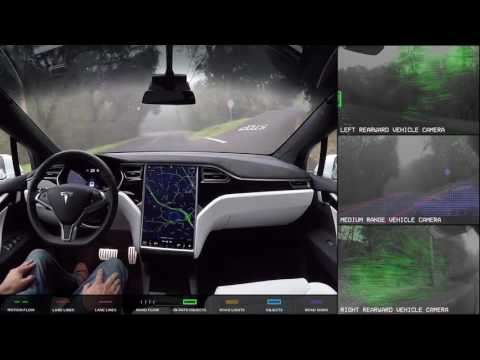

In [33]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('VG68SKoG7vE', width = 960, height = 540)

---

![](../graphics/spacer_small-01.png)

## **When might the Lucas Kanade method fail?**

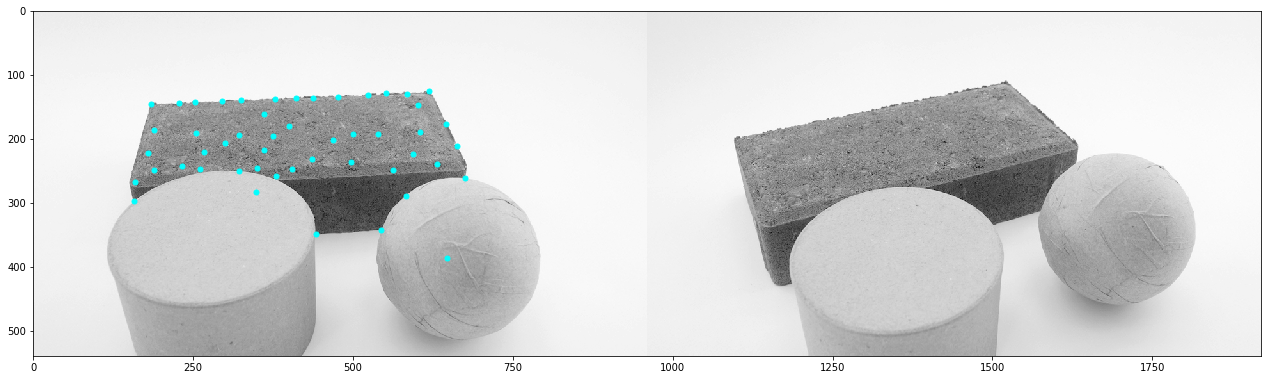

In [34]:
im2 = imread('../data/small/image_10.jpg')
gray_2 = cv2.cvtColor(im2, cv2.COLOR_RGB2GRAY)

images_together = np.hstack((gray_1, gray_2))

fig = figure(0, (22, 9))
imshow(images_together, cmap = 'gray')
scatter(corners[:, 0, 0], corners[:,0,1], c = (0, 1, 1), s = 25)

In [35]:
nextPts, status, err = cv2.calcOpticalFlowPyrLK(gray_1, gray_2, corners, None)

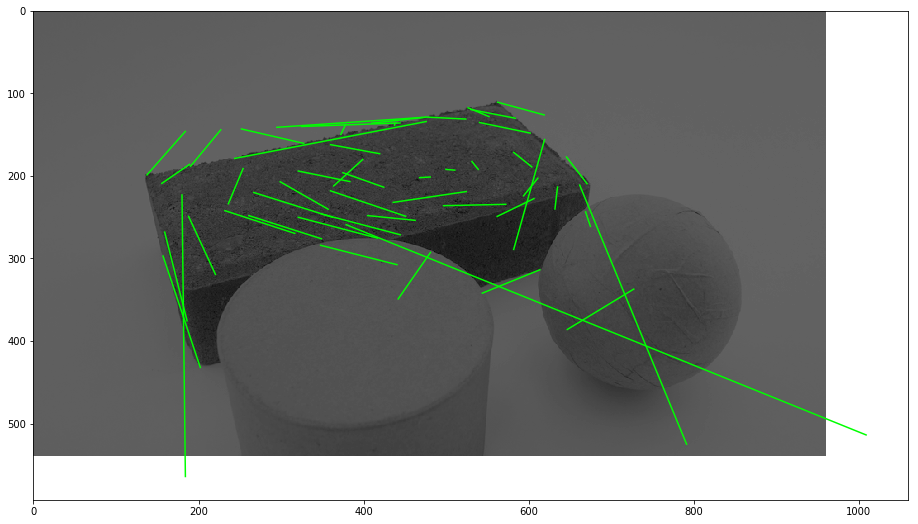

In [36]:
fig = figure(0, (22, 9))
imshow(gray_2*0.4, cmap = 'gray', vmax = 255, vmin = 0) #Darken image to make it easier to see flow lines

for i in range(nextPts.shape[0]):
    plot([corners[i, 0, 0], nextPts[i, 0, 0]], 
         [corners[i, 0, 1], nextPts[i, 0, 1]], alpha = 1.0, c = (0, 1, 0))

- Why is Lucas Kanade struggling here? Ideas?
- Here's our performance at different step sizes (step size = how far apart the frames we're comparing are)

![](../videos/lukas_kanade.gif)

---

![](../graphics/spacer_small-01.png)

## **SIFT**

- As we saw above, when our images change too much, the Lucas Kanade method struggles. This happends for a couple reasons. 

1. LK searches in the neighborhood of our old interest points, when our new points move to far from our old, it can be difficult for KL to converge. 
2. As we can see above, when our scene is viewed from a different angle, the appearance of our interest points changes. The appearance of our interest points can also change as a result of other factors (changes in lighting, occlusions, changes in scale...). This change in appearance can make interest points hard to track between images. 

- A large body of research is focused on solving these problems - the most well known solution is probably SIFT (Scale Invariant Feature Transform).

![](../graphics/sift_intro-01.png)

- David Lowe's SIFT algorithm combines a number of clever ideas and lots of experimentation to reliably detect and match keypoints between images. 
- One interesting idea used in SIFT is **Scale Space**. 
- By taking the difference of more and more blurred versions of the original image, it's possible to detect interest points at multiple scales. 
- This allows the intrest point detector to be scale invariant (this is the SI in SIFT).
- Again, we don't have time for a deep dive here, but David Lowe's [papers](https://link.springer.com/content/pdf/10.1023/B:VISI.0000029664.99615.94.pdf) present a very clear desciption of SIFT.

![](../graphics/sift_1-01.png)

---

- Another key idea from SIFT is the use of robust interest point descriptors. 

![](../graphics/sift_2-01.png)

- As shown in David Lowe's figure above, the SIFT descriptor uses orientation histograms over image patches. 
- These histograms are also made direction invariant by computing a dominant direction and shifting orientation histograms to point in the same direction
- Why might a histogram of orientations be more robust to lighting/scale/directional changes than a simple pixel to pixel comparison?

## **Now the bad news **

![](../graphics/no_sift_for_you-01.png)

- The SIFT algorithm is patented. 
- This means that you can't use it for commercial purposes. 
- SIFT was part of opencv 2, but not opencv 3 (although if you build from source, you can get it as part of contrib). 
- Finally, I did a little digging, and I belive that the SIFT patent will expire in March 2019.

- So, if we really wanted to use SIFT, we could use OpenCV 2, build opencv 3 from source with the contrib module, find another implementation, or impelement it ourselves. 
- However, there are some very good open source alternatives, we'll look at one called ORB. 

---

## ** ORB **

![](../graphics/orb-01.png)

- [ORB (Oriented Fast and Rotated Brief)](http://www.willowgarage.com/sites/default/files/orb_final.pdf) is a nice open source feature detector and descriptor out of Willow Garage. 
- ORB achieves similar performance to SIFT (although not quite as good in my experience), but is 2 orders of magnitude faster
- ORB makes use of and extends some previous work, specifically [FAST](https://www.edwardrosten.com/work/rosten_2006_machine.pdf) interest point detection, and [BRIEF](https://www.cs.ubc.ca/~lowe/525/papers/calonder_eccv10.pdf) feature descriptors. 
- Fun side note - the final author on the ORB paper, Gary Bradsky, was a member of the Stanford wining Darpa grand challenge team, and wrote the book on opencv. 
- Let's check out ORB!

In [37]:
ORB = cv2.ORB_create(nfeatures = 2000)

kpts1, des1 = ORB.detectAndCompute(gray_1, None)
kpts2, des2 = ORB.detectAndCompute(gray_2, None)

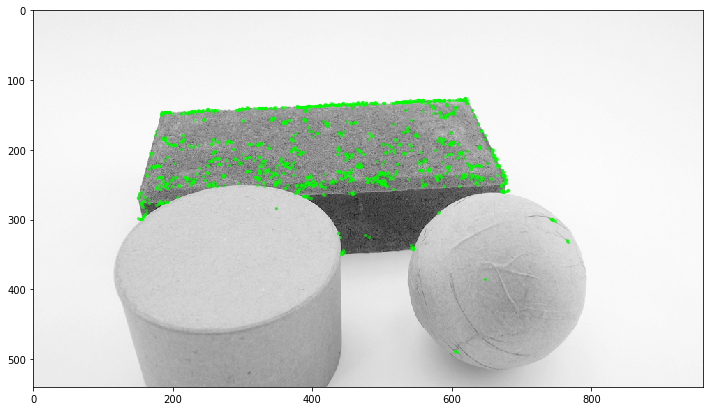

In [38]:
fig = figure(0, (12,12))
imshow(gray_1, cmap = 'gray')
for kpt in kpts1:
    scatter(kpt.pt[0], kpt.pt[1], c = (0, 1, 0), s = 5, alpha = 0.5)

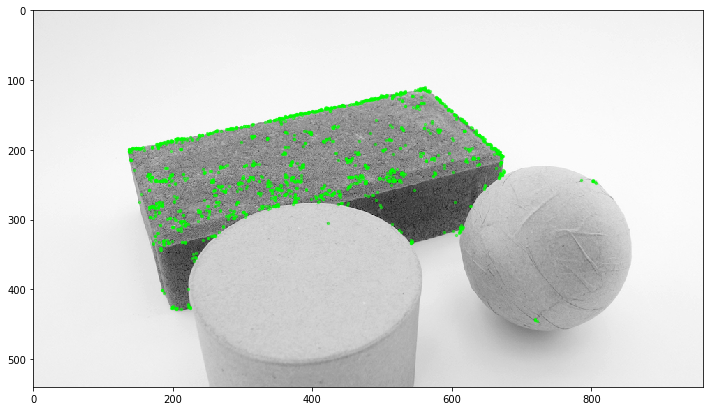

In [39]:
fig = figure(0, (12,12))
imshow(gray_2, cmap = 'gray')
for kpt in kpts2:
    scatter(kpt.pt[0], kpt.pt[1], c = (0, 1, 0), s = 5, alpha = 0.5)

- Notice that our ORB features pick up on the brick much more than the ball and cylinder. 
- This is due to the texture of the brick.
- OpenCV's orb class does not have non maximum supression built in, but there may be other ways to better distribute our keypoints. 
- For now, we won't worry about this too much.

## **The Descriptors**


In addition to detecting interest points, SIFT and ORB also compute robust interest points descriptors.

In [40]:
des1.shape

(1466, 32)

- Why is the the dimnsion of our descriptors?
- Just for fun, let's visualize the descriptors for a couple keypoints:

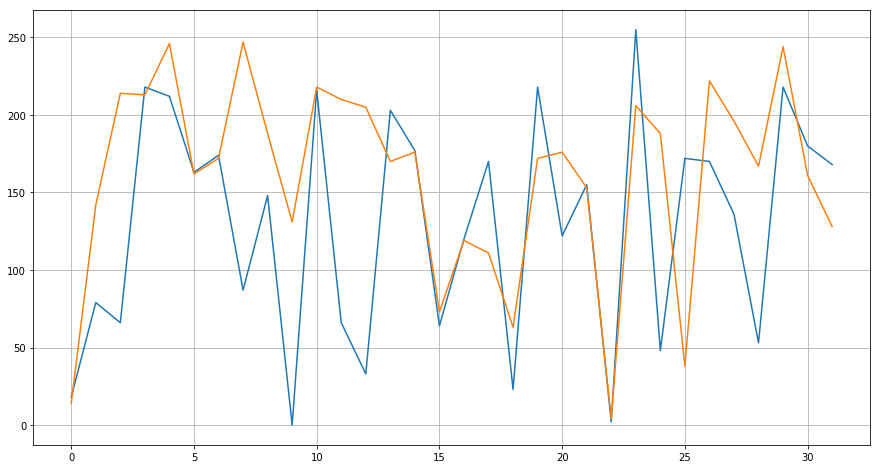

In [41]:
fig = figure(0, (15,8))
plot(des1[0, :].T);
grid(1)
plot(des1[1, :].T);

- The idea is, that a keypoints, even viewed under different lighting of from different perspectives, our descriptor should remain relatively constant. 
- Our job then is to match descriptors from our first image to descriptors in our second image. 
- Comparing all keypoints scales as $n^2$, where $n$ is the number of points, so as you can imagine conducting all these comparisons could be pretty slow.
- OpenCV has some [nice exact/brute force matchers, and some approximate matching methods](https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_matcher/py_matcher.html) when we need more speed, we'll use a brute force method here that compares all keypoints.

In [42]:
#create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING)

In [43]:
#Perform Matching, return 2 closest matches:
matches = bf.knnMatch(des1, des2, k=2)

In [44]:
len(matches)

1466

- Alright, so we've ended up with a good number of matches. 
- Now, to improve the qaulity of these matches, we'll borrow another idea from David Lowe
- It's possible for 2 seperate interest points in one image to be very similar to a single interest point in another
- One way to mitigate thie problem is the ratio test
- For each keypoint in one image, we'll compute the 2 nearest in the other image
- If the nearest descriptor is not much closer than the second nearest descriptor, we'll throw it out:

In [45]:
# Apply lowes' ratio test
matches_cleaned = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        matches_cleaned.append(m)

In [46]:
len(matches)

1466

In [47]:
len(matches_cleaned)

90

- You can see that we throw out alot of keypoints in this case using **Lowe's Ratio Test**!
- This wont' be so high for many other images, I the texture of the brick creates lots of False matches.
- Now we'll sort our matches by distance, closest matches first:

In [48]:
matches_cleaned = sorted(matches_cleaned, key = lambda x:x.distance)

- Let's quickly try to get a feel for how "close" our matches are.
- Here are the desciptors for our best match:

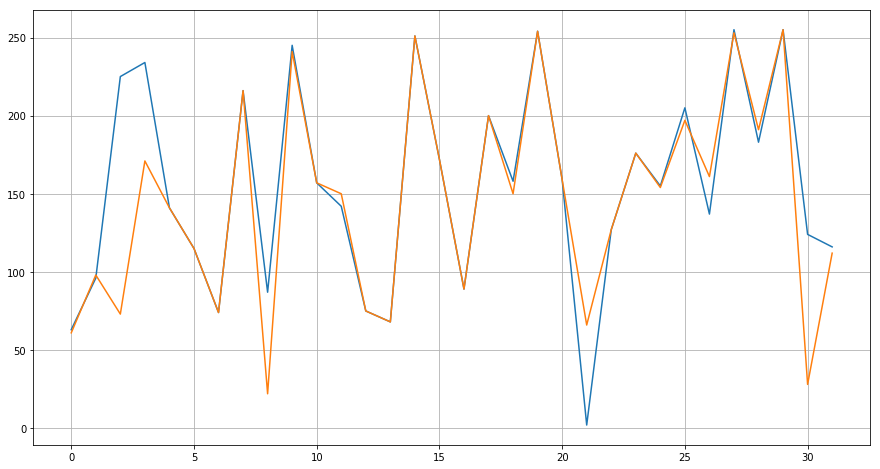

In [49]:
fig = figure(0, (15,8))
plot(des2[matches_cleaned[0].trainIdx, :].T);
grid(1)
plot(des1[matches_cleaned[0].queryIdx, :].T);

Let's have a quick look at the image patches around these keypoints.

In [50]:
index = 10

kpt = kpts1[matches_cleaned[index].queryIdx]
coords_1 = np.array(kpt.pt).astype('int')

kpt = kpts2[matches_cleaned[index].trainIdx]
coords_2 = np.array(kpt.pt).astype('int')

In [51]:
print(coords_1, coords_2)

[569 227] [573 212]


In [52]:
s = 10 #half neighborhood size
neighborhood_one = gray_1[coords_1[1]-s:coords_1[1]+s, coords_1[0]-s:coords_1[0]+s]
neighborhood_two = gray_2[coords_2[1]-s:coords_2[1]+s, coords_2[0]-s:coords_2[0]+s]

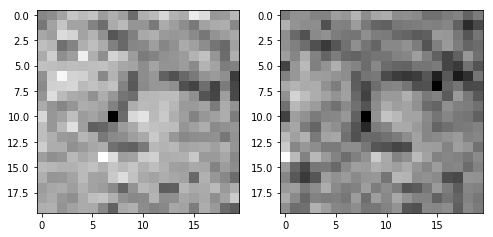

In [53]:
fig = figure(0, (8, 16))
fig.add_subplot(121)
imshow(neighborhood_one, cmap = 'gray')

fig.add_subplot(122)
imshow(neighborhood_two, cmap = 'gray')

- Alright, pretty good!
- Now, let's look at all our matches

- `matches_cleaned` just contians a list of match objects, not our original keypoints
- Let's sample our keypoints using the indices from our match objects

In [54]:
matching_keypoints_1 = []
matching_keypoints_2 = []

for match in matches_cleaned:
    matching_keypoints_1.append(kpts1[match.queryIdx])
    matching_keypoints_2.append(kpts2[match.trainIdx])

In [55]:
len(matching_keypoints_1)

90

## **And Finally, Visualize**

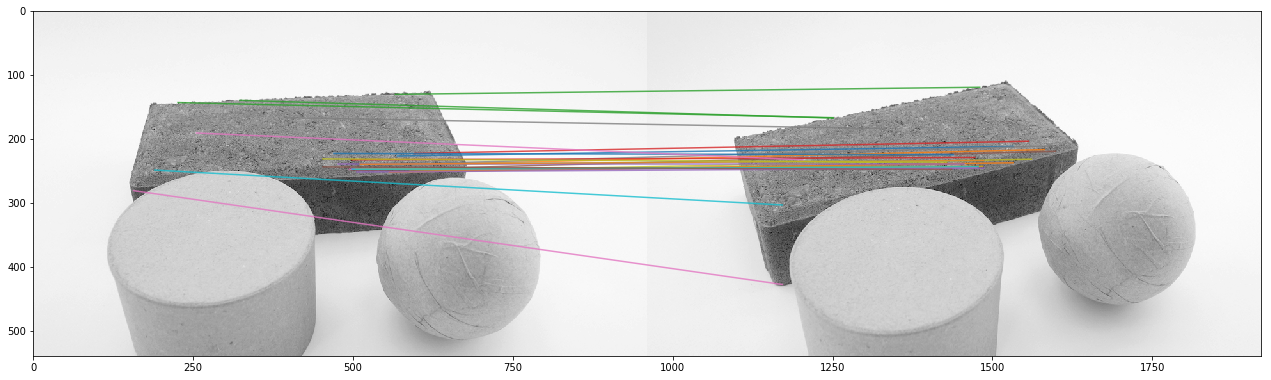

In [56]:
num_matches_to_show = 30 #Just show the first/best n matches here

fig = figure(0, (22, 9))
imshow(images_together, cmap = 'gray')

for i in range(len(matching_keypoints_1[:num_matches_to_show])):
    plot([matching_keypoints_1[i].pt[0], matching_keypoints_2[i].pt[0]+gray_1.shape[1]],
         [matching_keypoints_1[i].pt[1], matching_keypoints_2[i].pt[1]], alpha = 0.8)

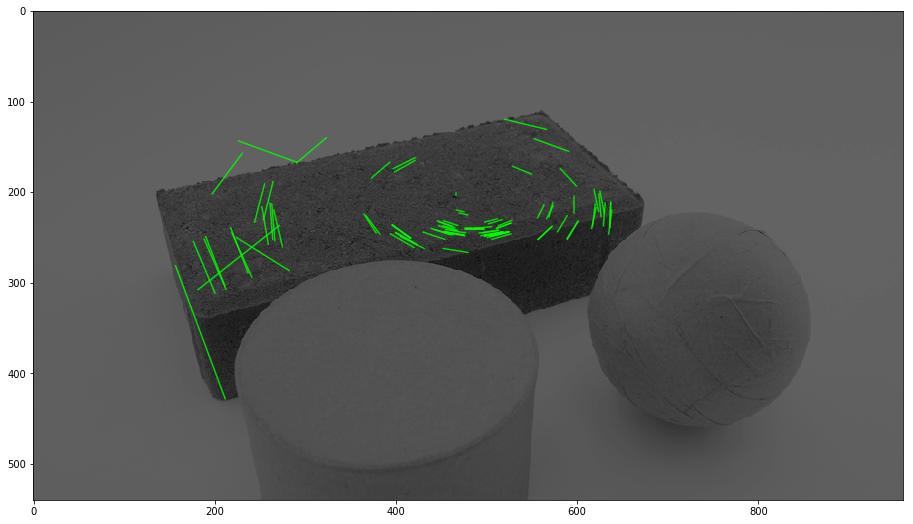

In [57]:
fig = figure(0, (22, 9))
imshow(gray_2*0.4, cmap = 'gray', vmax = 255, vmin = 0) #Darken image to make it easier to see flow lines

for i in range(len(matching_keypoints_1)):
    plot([matching_keypoints_1[i].pt[0], matching_keypoints_2[i].pt[0]],
         [matching_keypoints_1[i].pt[1], matching_keypoints_2[i].pt[1]], alpha = 0.8, c = (0, 1, 0))

- Pretty good matching for images that far apart, right?
- Now, notice that we are making *some* errors
- In our final lecture of this series, we'll discuss image transformation and RANSAC - and talk about a cool way to reject more incorrect matches by fitting a transformation model between frames. 


![](../videos/orb.gif)

![](../graphics/spacer_small-01.png)

---

## ** Are Interest Points Detectors and Descriptors Learnable?**

- As we've seen here, there are an enormous amount of heuristics and tuning that go into good feature detection and description. 
- All this work may leave you wondering if we can use data to learn better interest points detectors and descriptors...

![](../graphics/super_point_one-01.png)

- Magic Leap's [SuperPoint Algorithm](https://github.com/MagicLeapResearch/SuperPointPretrainedNetwork) is a terrific example of a smart application of deep learning to and old and important computer vision problem. 
- Now, you may be asking yourself...**where do they get their labels?** Do they sit around clickin on interest points all day? And how the heck would you create labels for learning a descriptor?


---

- In my opinion, this work from magic leap is very interesting, becuase they develop very smart ways to creating good trainig data. 
- They start with synthetic data to train an interest point detector
- And then use a very clever method they call homographic adaptation to **automatically create and label datasets** from real images. Check out the paper for full details. 
- Performance is quite good:

 ![](../graphics/super_point_two-01.png)

---

![](../videos/superpoint_1.gif)

- Super point is a bit noisy on our example here, we'll cover some methods to reject noisy matches in the transformations + RANSAC lecture.
- Notice how well tracked many of the interest points are!
- What's really remarkable is that SuperPoint was learned from data, and does not rely on a ton of manually tuned hueristics. 